In [12]:
# taking advantage of all features: codes by GenAI, based on my implementation using only voltage data
%load_ext autoreload
%autoreload 2

from utils import *
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

DATA_FRAC = 1.0
IS_REDUCED = DATA_FRAC < 0.3

# adj = np.zeros(N_NODES)
adj = load_adj_matrix('topology.csv')
centrality = np.sum(adj, axis=1, keepdims=True)
centrality = centrality / (centrality.max() + 1e-8)

def load_day_data(pkl):
    with open(pkl, 'rb') as f:
        data = pickle.load(f)

    # state variables
    v_sch, t_sch = data['sch_v'], data['sch_θ']
    v_att, t_att = data['attack_v'], data['attack_θ']

    # power flow (active/reactive on branches)
    fp_sch, fq_sch = data['sch_fp'], data['sch_fq']
    fp_att, fq_att = data['attack_fp'], data['attack_fq']

    # generation dispatch
    pg_sch, qg_sch = data['sch_pg'], data['sch_qg']
    pg_att, qg_att = data['attack_pg'], data['attack_qg']

    # load curtailment (storage control signals)
    dcurt_up_sch, dcurt_dn_sch = data['sch_dcurt_up'], data['sch_dcurt_dn']
    dcurt_up_att, dcurt_dn_att = data['attack_dcurt_up'], data['attack_dcurt_dn']

    attacked_nodes = [n - 1 for n in data['esset_btm']['A']]
    attack_window = data['timeset_a']['A']
    steps = [f"x{i}" for i in range(min(attack_window), max(attack_window) + 1)]
    if len(steps) == 0:
        return None

    V_sch = np.array([v_sch[s] for s in steps]).T
    T_sch = np.array([t_sch[s] for s in steps]).T
    V_att = np.array([v_att.get(s, v_sch[s]) for s in steps]).T
    T_att = np.array([t_att.get(s, t_sch[s]) for s in steps]).T

    # helper: safely load arrays with dimension handling
    def safe_load(d, s, n):
        if s not in d:
            return np.zeros(n)
        arr = np.asarray(d[s])
        return arr[:n] if len(arr) >= n else np.pad(arr, (0, n - len(arr)))

    # load all power system features
    Fp_sch = np.array([safe_load(fp_sch, s, N_NODES) for s in steps]).T
    Fq_sch = np.array([safe_load(fq_sch, s, N_NODES) for s in steps]).T
    Fp_att = np.array([safe_load(fp_att, s, N_NODES) for s in steps]).T
    Fq_att = np.array([safe_load(fq_att, s, N_NODES) for s in steps]).T
    Pg_sch = np.array([safe_load(pg_sch, s, N_NODES) for s in steps]).T
    Qg_sch = np.array([safe_load(qg_sch, s, N_NODES) for s in steps]).T
    Pg_att = np.array([safe_load(pg_att, s, N_NODES) for s in steps]).T
    Qg_att = np.array([safe_load(qg_att, s, N_NODES) for s in steps]).T
    Dcurt_up_sch = np.array([safe_load(dcurt_up_sch, s, N_NODES) for s in steps]).T
    Dcurt_dn_sch = np.array([safe_load(dcurt_dn_sch, s, N_NODES) for s in steps]).T
    Dcurt_up_att = np.array([safe_load(dcurt_up_att, s, N_NODES) for s in steps]).T
    Dcurt_dn_att = np.array([safe_load(dcurt_dn_att, s, N_NODES) for s in steps]).T

    # compute deviations (attack - scheduled)
    dV = V_att - V_sch
    dT = T_att - T_sch
    dFp, dFq = Fp_att - Fp_sch, Fq_att - Fq_sch
    dPg, dQg = Pg_att - Pg_sch, Qg_att - Qg_sch
    dDcurt_up, dDcurt_dn = Dcurt_up_att - Dcurt_up_sch, Dcurt_dn_att - Dcurt_dn_sch

    feats = []
    for diff in [dV, dT, dFp, dFq, dPg, dQg, dDcurt_up, dDcurt_dn]:
        feats.extend([
            diff.mean(axis=1, keepdims=True),
            diff.std(axis=1, keepdims=True),
            np.abs(diff).max(axis=1, keepdims=True),
            np.abs(diff).min(axis=1, keepdims=True),
            np.percentile(np.abs(diff), 75, axis=1, keepdims=True),
            np.percentile(np.abs(diff), 25, axis=1, keepdims=True),
        ])

    # baseline operational statistics
    feats.extend([
        V_sch.mean(axis=1, keepdims=True), V_sch.std(axis=1, keepdims=True),
        Fp_sch.mean(axis=1, keepdims=True), Fp_sch.std(axis=1, keepdims=True),
    ])
    feats.append(centrality)

    X = np.concatenate(feats, axis=1)
    y = np.zeros(N_NODES, dtype=np.float32)
    for node in attacked_nodes:
        y[node] = 1.0

    return X, y

print(f"FDIA detection | full features\n")
np.random.seed(10)

# base training data (v1-v3)
X_base, y_base, d_base = load_all_days(DATA_TRAIN, load_day_data, data_frac=DATA_FRAC)
# test data from v4 and v5
X_target, y_target, d_target = load_all_days(DATA_TEST, load_day_data, data_frac=DATA_FRAC)

# FEW-SHOT INJECTION
perm = np.random.permutation(len(X_target))
n_inject = 4
rand_idx = perm[:n_inject]
test_idx = perm[n_inject:]
# concat base train + injected target samples
X_train = np.concatenate([X_base, X_target[rand_idx]], axis=0)
y_train = np.concatenate([y_base, y_target[rand_idx]], axis=0)
d_train = d_base + [d_target[i] for i in rand_idx]

X_test = X_target[test_idx]   # remaining target data stays as test set
y_test = y_target[test_idx]
d_test = [d_target[i] for i in test_idx]

print(f"train data: {X_train.shape}, attack ratio={y_train.mean():.3f}")
print(f"test data: {X_test.shape}, attack ratio={y_test.mean():.3f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FDIA detection | full features



Loading v5 (174 days): 100%|██████████| 174/174 [00:03<00:00, 46.10it/s]


train data: (813, 187, 53), attack ratio=0.043
test data: (297, 187, 53), attack ratio=0.048


In [13]:
# normalize using train statistics
X_mean = X_train.mean((0, 1), keepdims=True)
X_std = X_train.std((0, 1), keepdims=True) + 1e-8
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

if IS_REDUCED:    # more aggressive training
    w = 0.5
    lr = 5e-4
    ep = 150
    batch = 16
else:
    w = 0.5
    lr = 2e-3
    ep = 400
    batch = 32

weight = (y_train.size - y_train.sum()) / (y_train.sum() + 1e-8) * w
print(f"{X_train.shape[0]} train + {X_test.shape[0]} test | positive class weight={weight:.1f}\n")

steps_per_ep = len(X_train) // batch
lr_sch = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr,
    decay_steps=ep * steps_per_ep,
    alpha=0.01
)

model = gcn(N_NODES, X_train.shape[2], adj, reduced_data=IS_REDUCED)
model.compile(
    optimizer=keras.optimizers.Adam(lr_sch), loss=WeightedBCE(pos_weight=weight),
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
        keras.metrics.Precision(name='prec', thresholds=0.5),
        keras.metrics.Recall(name='rec', thresholds=0.5),
        keras.metrics.AUC(name='auc')
    ]
)

hist = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=ep, batch_size=batch, verbose=1,
    #callbacks=[
        #keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max'),
        #keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, mode='max')
    #]
)

y_pred = model.predict(X_test, verbose=0)[:, :, 0]

813 train + 297 test | positive class weight=11.2

Epoch 1/400
26/26 [==============================] - 1s 19ms/step - loss: 0.9402 - acc: 0.8429 - prec: 0.1642 - rec: 0.6527 - auc: 0.8571 - val_loss: 1.1043 - val_acc: 0.9504 - val_prec: 0.3603 - val_rec: 0.0400 - val_auc: 0.7699
Epoch 2/400
26/26 [==============================] - 0s 11ms/step - loss: 0.6868 - acc: 0.8959 - prec: 0.2616 - rec: 0.7849 - auc: 0.9320 - val_loss: 1.0312 - val_acc: 0.9403 - val_prec: 0.3061 - val_rec: 0.1893 - val_auc: 0.7914
Epoch 3/400
26/26 [==============================] - 0s 10ms/step - loss: 0.5806 - acc: 0.9065 - prec: 0.2932 - rec: 0.8399 - auc: 0.9498 - val_loss: 0.9940 - val_acc: 0.9079 - val_prec: 0.2171 - val_rec: 0.3502 - val_auc: 0.7940
Epoch 4/400
26/26 [==============================] - 0s 10ms/step - loss: 0.5066 - acc: 0.9159 - prec: 0.3223 - rec: 0.8738 - auc: 0.9611 - val_loss: 0.9505 - val_acc: 0.9144 - val_prec: 0.2449 - val_rec: 0.3734 - val_auc: 0.8175
Epoch 5/400
26/26 [==========


Top 15 suspicious nodes (avg score across 297 test days):
  125: 1.000 [ATTACK]
  112: 0.999 [ATTACK]
  115: 0.999 [ATTACK]
  87: 0.995 [ATTACK]
  107: 0.982 [ATTACK]
  127: 0.971 
  113: 0.782 [ATTACK]
  131: 0.667 
  114: 0.536 
  130: 0.513 [ATTACK]
  128: 0.377 [ATTACK]
  104: 0.125 [ATTACK]
  86: 0.122 
  163: 0.085 
  124: 0.083 

Classification Report
              precision    recall  f1-score   support

      normal       0.99      0.98      0.99     52866
      attack       0.70      0.80      0.75      2673

    accuracy                           0.97     55539
   macro avg       0.85      0.89      0.87     55539
weighted avg       0.98      0.97      0.97     55539



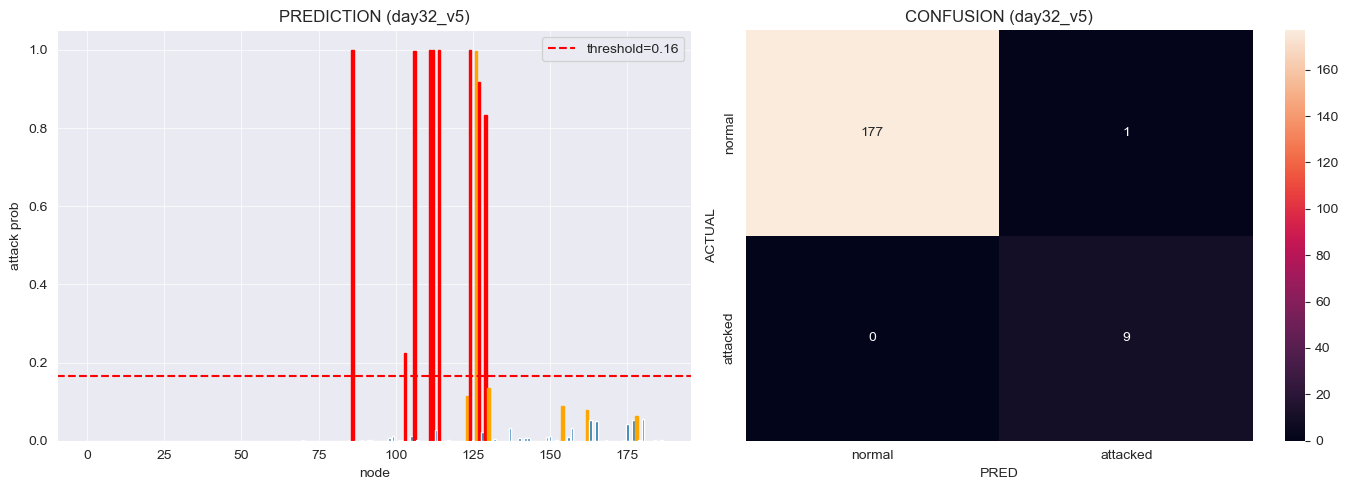

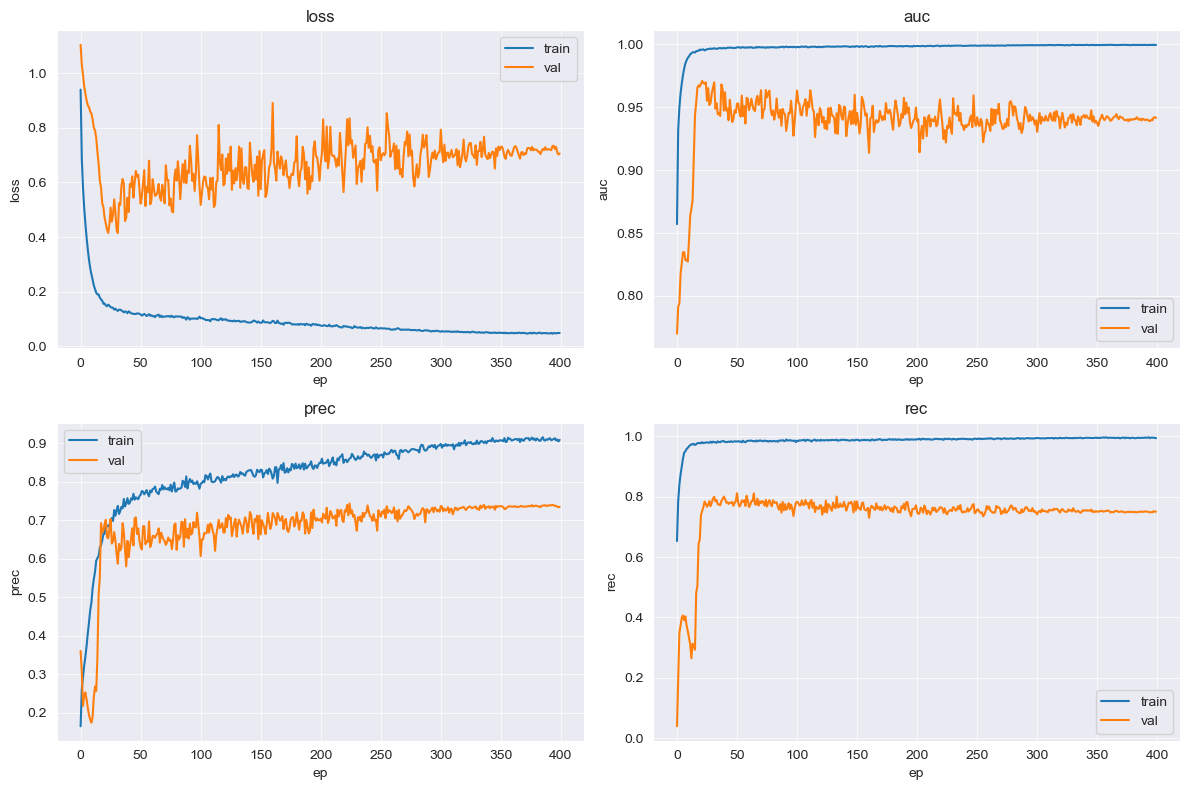

In [15]:
thresh = np.linspace(0.1, 0.9, 100)
f1 = []
beta = 1.5

for t in thresh:
    y_bin = (y_pred > t).astype(int)
    tp = ((y_bin == 1) & (y_test == 1)).sum()
    fp = ((y_bin == 1) & (y_test == 0)).sum()
    fn = ((y_bin == 0) & (y_test == 1)).sum()
    p = tp / (tp + fp + 1e-8)
    r = tp / (tp + fn + 1e-8)
    f1.append((1 + beta**2) * (p * r) / ((beta**2 * p) + r + 1e-8))

thresh_opt = thresh[np.argmax(f1)]
y_pred_bin = (y_pred > thresh_opt).astype(int)

print(f"\nTop 15 suspicious nodes (avg score across {X_test.shape[0]} test days):")
node_scores = y_pred.mean(axis=0)
for n in np.argsort(node_scores)[-15:][::-1]:
    attacked_str = '[ATTACK]' if y_test[:, n].sum() > 0 else ''
    print(f"  {n + 1}: {node_scores[n]:.3f} {attacked_str}")
print("\nClassification Report")
print(classification_report(y_test.flatten(), y_pred_bin.flatten(), target_names=['normal', 'attack']))

# visualization
idx = 33
day = d_test[idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bars = axes[0].bar(range(N_NODES), y_pred[idx])
axes[0].axhline(thresh_opt, c='r', ls='--', label=f'threshold={thresh_opt:.2f}')
attacked_nodes_idx = np.where(y_test[idx] == 1)[0]
for i in np.argsort(y_pred[idx])[-15:]:
    bars[i].set_color('red' if i in attacked_nodes_idx else 'orange')
axes[0].set(xlabel='node', ylabel='attack prob', title=f'PREDICTION ({day})')
axes[0].legend()
axes[0].grid(alpha=0.7)

sns.heatmap(confusion_matrix(y_test[idx], y_pred_bin[idx]), fmt='d', annot=True, ax=axes[1])
axes[1].set(xlabel='PRED', ylabel='ACTUAL', title=f'CONFUSION ({day})')
axes[1].set_xticklabels(['normal', 'attacked'])
axes[1].set_yticklabels(['normal', 'attacked'])

plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, k in enumerate(['loss', 'auc', 'prec', 'rec']):
    ax = axes[i // 2, i % 2]
    ax.plot(hist.history[k], label='train')
    ax.plot(hist.history[f'val_{k}'], label='val')
    ax.set(xlabel='ep', ylabel=k, title=k)
    ax.legend()
    ax.grid(alpha=0.7)

plt.tight_layout()